### Customized convolutional neural network for image classification

pp. 79 ~


Download the data first, using following commands (type in Terminal) in the upper directory.

$  cd ..
    
$  wget https://download.pytorch.org/tutorial/hymenoptera_data.zip 

$  unzip hymenoptera_data.zip

In the hymenoptera_data folder, the images are stored in `\train` and `\val` directories, where the two folders, `\ants` and `\bees` are located. The `\ants` and `\bees` folders respectively include the images belong to ants and bees.

Therefore,

> train
>> ants
>
>> bees

>val
>> ants
>
>> bees

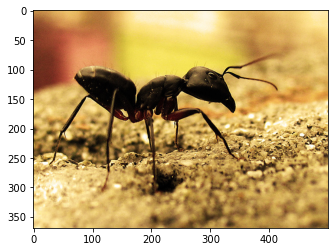

In [1]:
# 1-1 Read the images using OpenCV
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('../hymenoptera_data/train/ants/649026570_e58656104b.jpg')

# Change the channel from BGR to RGB, because the default color channel of OpenCV is BGR 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image 
plt.imshow(img)
plt.show()

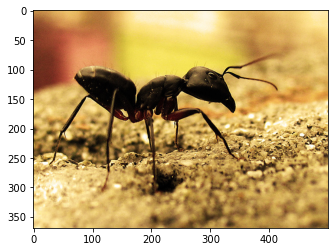

In [2]:
# 1-2 Read the images using Pillow 

from PIL import Image

image = "../hymenoptera_data/train/ants/649026570_e58656104b.jpg"
with open(image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')

# Display the image
plt.imshow(image)
plt.show()

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os

In [4]:
# 2. Preprocess the image data using torchvision

# Define the preprocessing of the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Preprocessing without normalization
to_tensor_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
# # Define custom dataset using torch.utils.data.Dataset
# # Example format 

# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self):
#         # 1. Initialize the file path or file name
#         pass
#     def __getitem__(self, index):
#         # 1. Read file by picking one data by using numpy.fromfile, PIL.Image.open
#         # 2. Preprocess the data using torchvision.Transform
#         # 3. Return the pair (image and label)
#         pass
#     def __len__(self):
#         # set as the least, 0 
#         return 0
    
# # Load the predefined data

# custom_dataset = CustomDataset()
# train_loader = torch.utils.data.DataLoader(dataset = custom_dataset, batch_size= 64, shuffle=True)

In [8]:
# Custom dataset for ants and bees

root = '../hymenoptera_data/'
class CustomDataset(torch.utils.data.Dataset):
    classes = ['ant', 'bee']
    
    def __init__(self, root, transform=None, train=True):
        # if designated, take the preprocessing class
        self.transform = transform
        
        # list that preserves the images and labels
        self.images = []
        self.labels = []
        # root folder path
        root = "../hymenoptera_data/"
        
        # Separate the cases: train and test
        # Retrieve the images from the path
        if train == True:
            root_ants_path = os.path.join(root, 'train', 'ants')
            root_bees_path = os.path.join(root, 'train', 'bees')
        else:
            root_ants_path = os.path.join(root, 'val', 'ants')
            root_bees_path = os.path.join(root, 'val', 'bees')  
        
        # Retrieve the images of ants
        ant_images = os.listdir(root_ants_path) # os.listdir() returns the list of all files and directories in the designated path
        # let ants be labeled as 0
        ant_labels = [0]*len(ant_images)
        # Retrieve the images of bees
        bee_images = os.listdir(root_bees_path) # os.listdir() returns the list of all files and directories in the designated path
        # let bees be labeled as 1
        bee_labels = [1]*len(bee_images)
        # Convert them all into a list
        for image, label in zip(ant_images, ant_labels):
            self.images.append(os.path.join(root_ants_path, image))
            self.labels.append(label)
        for image, label in zip(bee_images, bee_labels):
            self.images.append(os.path.join(root_bees_path, image))
            self.labels.append(label)
    
    def __getitem__(self, index):
        # Retrieve the images and labels based on index
        image = self.images[index]
        label = self.labels[index]
        # Read the image from the path
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        # preprocess if required
        if self.transform is not None:
            image = self.transform(image)
        # return the pair of image and label
        return image, label
    
    def __len__(self):
        # return the number of data
        return len(self.images)

[0 1 0 1 0]


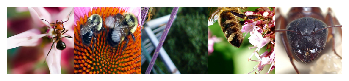

In [11]:
# Show the images read by CustomDataset

custom_dataset = CustomDataset(root, to_tensor_transforms, train=True)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset, batch_size=5, shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

In [17]:
# DEFINE THE NETWORK: by mimicking AlexNet

num_classes = 2

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), # note that padding has been changed form 5 to 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # changed from linear classifier to linear+ relu
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [20]:
# Optional: check the output size of the image after processed through AlexNet

size_check = torch.FloatTensor(10,3,224,224) # batch size = 10, 
features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

print(features(size_check).size())
print(features(size_check).view(size_check.size(0),-1).size())
fc_size = features(size_check).view(size_check.size(0),-1).size()[1] # for fully connected layer
print(fc_size)

torch.Size([10, 256, 6, 6])
torch.Size([10, 9216])
9216


In [21]:
# Therefore, the initial size of the classifier should be fc_size, as calculated above.
# The modified AlexNet should be as follow.

num_classes = 2

class AlexNet(nn.Module):
    def __init__(self, num_classes, fc_size):  #modification 1
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096),  # fc_size is transfered from the feature block (modification 2)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes, fc_size).to(device) #  modification 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [26]:
train_dataset = CustomDataset(root, to_tensor_transforms, train=True)
test_dataset = CustomDataset(root, to_tensor_transforms, train=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

In [27]:
# TRAIN THE NETWORK


num_epochs = 100

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.0708, val_loss: 0.0725, val_acc: 0.5425
Epoch [2/100], Loss: 0.0709, val_loss: 0.0725, val_acc: 0.4575
Epoch [3/100], Loss: 0.0709, val_loss: 0.0732, val_acc: 0.4575
Epoch [4/100], Loss: 0.0709, val_loss: 0.0723, val_acc: 0.5425
Epoch [5/100], Loss: 0.0709, val_loss: 0.0728, val_acc: 0.4575
Epoch [6/100], Loss: 0.0707, val_loss: 0.0725, val_acc: 0.5425
Epoch [7/100], Loss: 0.0708, val_loss: 0.0724, val_acc: 0.5425
Epoch [8/100], Loss: 0.0708, val_loss: 0.0725, val_acc: 0.5425
Epoch [9/100], Loss: 0.0708, val_loss: 0.0731, val_acc: 0.4575
Epoch [10/100], Loss: 0.0711, val_loss: 0.0724, val_acc: 0.5425
Epoch [11/100], Loss: 0.0709, val_loss: 0.0732, val_acc: 0.4575
Epoch [12/100], Loss: 0.0708, val_loss: 0.0725, val_acc: 0.5425
Epoch [13/100], Loss: 0.0708, val_loss: 0.0725, val_acc: 0.4575
Epoch [14/100], Loss: 0.0708, val_loss: 0.0727, val_acc: 0.4575
Epoch [15/100], Loss: 0.0708, val_loss: 0.0727, val_acc: 0.4575
Epoch [16/100], Loss: 0.0708, val_loss: 0.0727, v

#### Other method for dataset preparation: ImageFolder

In [29]:
# read images and labels

from torchvision import datasets

data_dir = '../hymenoptera_data/'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=4)

In [30]:
# TRAIN THE NETWORK


num_epochs = 100

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.1394, val_loss: 0.1399, val_acc: 0.5882
Epoch [2/100], Loss: 0.1397, val_loss: 0.1430, val_acc: 0.4575
Epoch [3/100], Loss: 0.1400, val_loss: 0.1407, val_acc: 0.4575
Epoch [4/100], Loss: 0.1399, val_loss: 0.1416, val_acc: 0.4575
Epoch [5/100], Loss: 0.1395, val_loss: 0.1406, val_acc: 0.4575
Epoch [6/100], Loss: 0.1398, val_loss: 0.1415, val_acc: 0.4575
Epoch [7/100], Loss: 0.1403, val_loss: 0.1402, val_acc: 0.5425
Epoch [8/100], Loss: 0.1399, val_loss: 0.1401, val_acc: 0.5425
Epoch [9/100], Loss: 0.1407, val_loss: 0.1423, val_acc: 0.4575
Epoch [10/100], Loss: 0.1396, val_loss: 0.1404, val_acc: 0.5425
Epoch [11/100], Loss: 0.1395, val_loss: 0.1407, val_acc: 0.4575
Epoch [12/100], Loss: 0.1405, val_loss: 0.1412, val_acc: 0.4575
Epoch [13/100], Loss: 0.1398, val_loss: 0.1415, val_acc: 0.4575
Epoch [14/100], Loss: 0.1396, val_loss: 0.1410, val_acc: 0.4575
Epoch [15/100], Loss: 0.1404, val_loss: 0.1398, val_acc: 0.5425
Epoch [16/100], Loss: 0.1397, val_loss: 0.1405, v

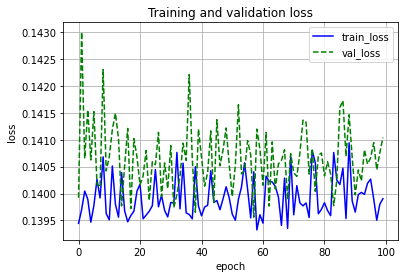

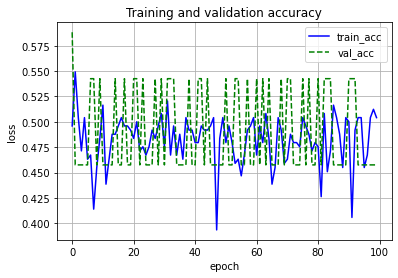

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

In [ ]:
# Note that the Convolutional network outperforms the MLP network